# Lexicon Team - Multilingual Sentiment Lexicon Development

This notebook consolidates all lexicon processing work, including:
- Loading and cleaning the original French lexicon
- Creating unique entries and deduplication
- GCP Translation API integration (French → English)
- Quality control and validation
- Final enriched lexicon generation

## Step 1: Setup and Imports

## Step 0: Google Cloud Platform (GCP) Setup

**IMPORTANT**: Configure GCP credentials before running translation cells.

This notebook uses Google Cloud Translation API for translating:
- French → English (lexicon)
- French → Afrikaans, Tsonga, Zulu (corpus)

**Requirements:**
- Google Cloud project with Translation API enabled
- Service account JSON key file
- Project ID from GCP Console

### Install Required Packages

Run this cell first to install the Google Cloud Translation library.

In [23]:
# Install Google Cloud Translation library
!pip install google-cloud-translate python-dotenv

  Obtaining dependency information for google-cloud-translate from https://files.pythonhosted.org/packages/89/f9/f32ffce070e56bd455f70953df65ed0ea87d6d35cb3a6b18385a8c31ca9e/google_cloud_translate-3.22.0-py3-none-any.whl.metadata
  Obtaining dependency information for python-dotenv from https://files.pythonhosted.org/packages/14/1b/a298b06749107c305e1fe0f814c6c74aea7b2f1e10989cb30f544a1b3253/python_dotenv-1.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for google-api-core[grpc]!=2.0.*,!=2.1.*,!=2.10.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,!=2.9.*,<3.0.0,>=1.34.1 from https://files.pythonhosted.org/packages/ed/d4/90197b416cb61cefd316964fd9e7bd8324bcbafabf40eef14a9f20b81974/google_api_core-2.28.1-py3-none-any.whl.metadata
  Obtaining dependency information for google-auth!=2.24.0,!=2.25.0,<3.0.0,>=2.14.1 from https://files.pythonhosted.org/packages/92/05/adeb6c495aec4f9d93f9e2fc29eeef6e14d452bba11d15bdb874ce1d5b10/google_auth-2.42.1-py2.py3-none-any.w

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python312\\Scripts\\dotenv.exe' -> 'C:\\Python312\\Scripts\\dotenv.exe.deleteme'


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


### Configure GCP Credentials

In [11]:
# ============================================================================
# CONFIGURE GCP CREDENTIALS
# ============================================================================
import os

# Set your GCP credentials
SERVICE_ACCOUNT_KEY = r"C:\Users\User\Downloads\multilingualtranlation-c44ef17df27a.json"
PROJECT_ID = "multilingualtranlation"  # Update this with your actual GCP Project ID

# Configure environment variables
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SERVICE_ACCOUNT_KEY
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

print("=" * 70)
print("GCP CONFIGURATION")
print("=" * 70)
print(f"✅ Service Account Key: {SERVICE_ACCOUNT_KEY}")
print(f"✅ Project ID: {PROJECT_ID}")
print()
print("🔄 Testing connection to GCP Translation API...")

# Test the connection
try:
    from google.cloud import translate_v2 as translate
    
    client = translate.Client()
    
    # Test translation
    test_result = client.translate("Bonjour", target_language="en")
    
    print(f"✅ GCP Translation API is working!")
    print(f"   Test: 'Bonjour' → '{test_result['translatedText']}'")
    print()
    print("=" * 70)
    print("✅ GCP READY - You can now run translation cells")
    print("=" * 70)
    
except Exception as e:
    print(f"❌ ERROR: Could not connect to GCP Translation API")
    print(f"   Error details: {str(e)}")
    print()
    print("📋 Troubleshooting:")
    print("   1. Verify your JSON file path is correct")
    print("   2. Check that Translation API is enabled in GCP Console")
    print("   3. Verify your Project ID is correct")
    print("   4. Install required package: pip install google-cloud-translate")
    print("=" * 70)

GCP CONFIGURATION
✅ Service Account Key: C:\Users\User\Downloads\multilingualtranlation-c44ef17df27a.json
✅ Project ID: multilingualtranlation

🔄 Testing connection to GCP Translation API...
✅ GCP Translation API is working!
   Test: 'Bonjour' → 'Good morning'

✅ GCP READY - You can now run translation cells
✅ GCP Translation API is working!
   Test: 'Bonjour' → 'Good morning'

✅ GCP READY - You can now run translation cells


In [12]:
# ============================================================================
# IMPORTS
# ============================================================================
from pathlib import Path
import pandas as pd
import numpy as np
import re
import os
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

print("✅ Imports successful")

✅ Imports successful


In [13]:
# ============================================================================
# OUTPUT PATH CONFIGURATION
# ============================================================================
# Define all output paths in one place for consistency
import os
from pathlib import Path

# Base directory for outputs
BASE_DIR = Path(r"C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3")

# Lexicon output paths
LEXICON_CLEANED = BASE_DIR / "lexicon_french_cleaned.csv"
LEXICON_UNIQUE = BASE_DIR / "lexicon_french_unique.csv"
LEXICON_ENRICHED = BASE_DIR / "lexicon_french_enriched.csv"
LEXICON_COMPLETE = BASE_DIR / "lexicon_complete_multilingual.csv"

# Corpus output paths
CORPUS_FRENCH = BASE_DIR / "corpus_french.csv"
CORPUS_MULTILINGUAL = BASE_DIR / "multilingual_corpus.csv"
CORPUS_STANDARD = BASE_DIR / "multilingual_corpus_standard.csv"
CORPUS_TRAIN = BASE_DIR / "multilingual_train.csv"
CORPUS_TEST = BASE_DIR / "multilingual_test.csv"

# QC output paths
CORPUS_COVERAGE = BASE_DIR / "corpus_coverage.txt"
OOV_CANDIDATES = BASE_DIR / "oov_candidates.csv"
CANDIDATE_ENRICHMENT = BASE_DIR / "candidate_enrichment.csv"
QC_SUMMARY = BASE_DIR / "corpus_qc_summary.txt"

print("✅ Output paths configured")
print(f"📂 Base directory: {BASE_DIR}")
print(f"\n📄 Lexicon files:")
print(f"   - {LEXICON_CLEANED.name}")
print(f"   - {LEXICON_UNIQUE.name}")
print(f"   - {LEXICON_ENRICHED.name}")
print(f"   - {LEXICON_COMPLETE.name}")
print(f"\n📄 Corpus files:")
print(f"   - {CORPUS_FRENCH.name}")
print(f"   - {CORPUS_MULTILINGUAL.name}")
print(f"   - {CORPUS_STANDARD.name}")

✅ Output paths configured
📂 Base directory: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3

📄 Lexicon files:
   - lexicon_french_cleaned.csv
   - lexicon_french_unique.csv
   - lexicon_french_enriched.csv
   - lexicon_complete_multilingual.csv

📄 Corpus files:
   - corpus_french.csv
   - multilingual_corpus.csv
   - multilingual_corpus_standard.csv


## Step 2: Load Original Lexicon Data

In [14]:
# ============================================================================
# LOAD ORIGINAL LEXICON
# ============================================================================
# Load the original lexicon file (6000 words)
# This contains French words with sentiment scores

lexicon_path = r"C:\Users\User\Desktop\Assignment 3\lexicon_original.csv"

if not Path(lexicon_path).exists():
    # Fallback to xlsx if CSV not available
    lexicon_path = "lexicon_6000 words.xlsx"
    df_original = pd.read_excel(lexicon_path)
else:
    # Try different encodings for French text files
    try:
        df_original = pd.read_csv(lexicon_path, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            df_original = pd.read_csv(lexicon_path, encoding='latin-1')
        except UnicodeDecodeError:
            df_original = pd.read_csv(lexicon_path, encoding='cp1252')

print(f"📊 Loaded {len(df_original)} rows from original lexicon")
print(f"\nColumns: {df_original.columns.tolist()}")
print(f"\nFirst few rows:")
df_original.head(10)

📊 Loaded 6963 rows from original lexicon

Columns: ['CILUBA', 'French', 'Score', 'Sentiment', 'Nature', 'Unnamed: 5']

First few rows:


,CILUBA,French,Score,Sentiment,Nature,Unnamed: 5
0,Akaja,Arrange,1.0,Positif,Verbe,NaN
1,Akajilula,Rearrange,1.0,Positif,Verbe,NaN
2,Akula,Parle,2.0,Positif,Verbe,NaN
3,Akulula,Reparle,2.0,Positif,Verbe,NaN
4,Aluja,Remet,3.0,Positif,Verbe,NaN
5,Amba,Dis,3.0,Positif,Verbe,NaN
6,Ambakaja,Supperpose,3.0,Positif,Verbe,NaN
7,Ambula,Ramasse,4.0,Positif,Verbe,NaN
8,Ambuluja,Depeche,4.0,Positif,Verbe,NaN
9,Ambulula,Repete,9.0,Positif,Verbe,NaN


In [15]:
# ============================================================================
# INITIAL DATA QUALITY CHECK
# ============================================================================
print("📋 Data Quality Summary:")
print("=" * 60)
print(f"\nTotal entries: {len(df_original)}")
print(f"\nMissing values per column:")
print(df_original.isnull().sum())
print(f"\nData types:")
print(df_original.dtypes)

# Check for duplicates
if 'french' in df_original.columns:
    duplicates = df_original['french'].duplicated().sum()
    print(f"\n🔍 Duplicate French entries: {duplicates}")

📋 Data Quality Summary:

Total entries: 6963

Missing values per column:
CILUBA           2
French           9
Score            5
Sentiment        3
Nature           1
Unnamed: 5    6963
dtype: int64

Data types:
CILUBA         object
French         object
Score         float64
Sentiment      object
Nature         object
Unnamed: 5    float64
dtype: object


## Step 3: Clean French Entries

This step normalizes the French text:
- Removes extra whitespace
- Fixes encoding issues
- Standardizes sentiment labels
- Validates part-of-speech tags

In [16]:
# ============================================================================
# CLEAN FRENCH COLUMN
# ============================================================================

def clean_text(text):
    """Clean and normalize text entries"""
    if pd.isna(text):
        return ""
    
    text = str(text).strip()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Lowercase for consistency
    text = text.lower()
    return text

def fix_sentiment(s):
    """Standardize sentiment labels"""
    if pd.isna(s):
        return "neutral"
    s = str(s).strip().lower()
    if s in ['positif', 'positive', 'pos', '+']:
        return "positive"
    elif s in ['negatif', 'negative', 'négatif', 'neg', '-']:
        return "negative"
    else:
        return "neutral"

# Apply cleaning
df_clean = df_original.copy()

# Normalize column names to lowercase
df_clean.columns = df_clean.columns.str.lower().str.strip()

# Clean French column
if 'french' in df_clean.columns:
    df_clean['french_original'] = df_clean['french']
    df_clean['french'] = df_clean['french'].apply(clean_text)
    print(f"✅ Cleaned French column")

# Standardize sentiment
if 'sentiment' in df_clean.columns:
    df_clean['sentiment_original'] = df_clean['sentiment']
    df_clean['sentiment'] = df_clean['sentiment'].apply(fix_sentiment)
    print(f"✅ Standardized sentiment labels")

# Remove empty French entries
df_clean = df_clean[df_clean['french'].str.len() > 0]

print(f"\n📊 After cleaning: {len(df_clean)} entries")
print(f"\nSentiment distribution:")
print(df_clean['sentiment'].value_counts())

✅ Cleaned French column
✅ Standardized sentiment labels

📊 After cleaning: 6954 entries

Sentiment distribution:
sentiment
positive    4574
neutral     1242
negative    1138
Name: count, dtype: int64


In [17]:
# Save cleaned version
LEXICON_CLEANED.parent.mkdir(parents=True, exist_ok=True)
df_clean.to_csv(LEXICON_CLEANED, index=False)
print(f"💾 Saved cleaned lexicon to: {LEXICON_CLEANED}")

💾 Saved cleaned lexicon to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\lexicon_french_cleaned.csv


## Step 4: Create Unique Entries

Deduplicate the lexicon by:
- Grouping by normalized French text
- Keeping the best representative for each group
- Prioritizing entries with complete data

In [30]:
# ============================================================================
# CREATE UNIQUE ENTRIES
# ============================================================================

def priority_from_score(score):
    """Assign priority based on sentiment score strength"""
    try:
        score = float(score)
        if abs(score) >= 0.5:
            return 1  # Strong sentiment
        elif abs(score) >= 0.2:
            return 2  # Medium sentiment
        else:
            return 3  # Weak sentiment
    except:
        return 4  # No valid score

def pick_representative(group: pd.DataFrame) -> pd.Series:
    """Select the best representative entry from a group of duplicates"""
    # Priority rules:
    # 1. Has sentiment score
    # 2. Has English translation
    # 3. Has nature/POS tag
    # 4. Strongest sentiment score
    
    if len(group) == 1:
        return group.iloc[0]
    
    # Add priority column
    if 'score' in group.columns:
        group = group.copy()
        group['_priority'] = group['score'].apply(priority_from_score)
        # Sort by priority, then by completeness
        group = group.sort_values('_priority')
    
    return group.iloc[0]

# Group by French word and pick best representative
print("🔍 Identifying duplicates...")

# Use drop_duplicates with a custom key function approach
# First, add priority scores to help with deduplication
df_clean_copy = df_clean.copy()
if 'score' in df_clean_copy.columns:
    df_clean_copy['_priority'] = df_clean_copy['score'].apply(priority_from_score)
else:
    df_clean_copy['_priority'] = 4

# Sort by french word and priority
df_clean_copy = df_clean_copy.sort_values(['french', '_priority'])

# Keep first occurrence (best priority) for each french word
df_unique = df_clean_copy.drop_duplicates(subset=['french'], keep='first').copy()

# Remove temporary priority column
if '_priority' in df_unique.columns:
    df_unique = df_unique.drop(columns=['_priority'])

# Reset index
df_unique = df_unique.reset_index(drop=True)

# Verify the french column still exists
if 'french' not in df_unique.columns:
    print("⚠️ ERROR: 'french' column missing after deduplication!")
    print(f"   Available columns: {df_unique.columns.tolist()}")
else:
    print(f"✅ 'french' column verified")

print(f"\n📊 Deduplication results:")
print(f"   Original entries: {len(df_clean)}")
print(f"   Unique entries: {len(df_unique)}")
print(f"   Removed duplicates: {len(df_clean) - len(df_unique)}")

# Verify we have the expected columns
print(f"\n📋 Columns in df_unique: {df_unique.columns.tolist()}")

# Show examples of deduplicated groups
print(f"\n🔍 Example deduplicated entries:")
df_unique.head(10)


🔍 Identifying duplicates...
✅ 'french' column verified

📊 Deduplication results:
   Original entries: 6954
   Unique entries: 3651
   Removed duplicates: 3303

📋 Columns in df_unique: ['ciluba', 'french', 'score', 'sentiment', 'nature', 'unnamed: 5', 'french_original', 'sentiment_original']

🔍 Example deduplicated entries:


,ciluba,french,score,sentiment,nature,unnamed: 5,french_original,sentiment_original
0,tshishikula tshimue ne mbombo inayi ne binunu ...,144,0.0,neutral,Mot,NaN,144,Neutre
1,Tshiendelele,a jamais,9.0,positive,Mot,NaN,A Jamais,Positif
2,Kupuekela,abaissement,3.0,positive,Mot,NaN,abaissement,Positif
3,Kulekela,abandon,3.0,positive,Mot,NaN,abandon,Positif
4,kulekela,abandonner,4.0,positive,Verbe,NaN,Abandonner,Positif
5,Mukumike,abattu,3.0,positive,Mot,NaN,abattu,Positif
6,Lubulubulu,abeille,5.0,positive,Mot,NaN,Abeille,Positif
7,kubenga,abhorrer,4.0,positive,Verbe,NaN,Abhorrer,Positif
8,Kunianga,abimer,-4.0,negative,Verbe,NaN,abimer,Negatif
9,tshidi tshinyanguka,abimé,0.0,neutral,Mot,NaN,abimé,Neutre


In [31]:
# Save unique version
df_unique.to_csv(LEXICON_UNIQUE, index=False)
print(f"💾 Saved unique lexicon to: {LEXICON_UNIQUE}")

💾 Saved unique lexicon to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\lexicon_french_unique.csv


## Step 5: GCP Translation (French → English)

**Note**: This step requires Google Cloud Platform credentials.  
If you don't have GCP access, skip to Step 6 which uses pre-translated data.

In [20]:
# ============================================================================
# GCP TRANSLATION SETUP (OPTIONAL)
# ============================================================================
# This cell checks if GCP credentials are available
# If not available, we'll use pre-translated data

GCP_AVAILABLE = False

try:
    from dotenv import load_dotenv, find_dotenv
    load_dotenv(find_dotenv())
    
    if os.getenv("GOOGLE_APPLICATION_CREDENTIALS") and os.getenv("GOOGLE_CLOUD_PROJECT"):
        from google.cloud import translate
        GCP_AVAILABLE = True
        print("✅ GCP credentials found - translation available")
    else:
        print("⚠️ GCP credentials not found - will use pre-translated data")
except Exception as e:
    print(f"⚠️ GCP not available: {e}")
    print("   Will use pre-translated data instead")

✅ GCP credentials found - translation available


In [32]:
# ============================================================================
# TRANSLATE FRENCH → ENGLISH (if GCP available)
# ============================================================================

if GCP_AVAILABLE:
    from google.cloud import translate
    import time
    from tqdm.auto import tqdm
    
    # Idiom overrides for better translation
    POST_OVERRIDE = {
        "pas mal": "pretty good",
        "pas mauvais": "not bad (pretty good)",
        "pas terrible": "not great",
        "au top": "top-notch",
        "trop bien": "awesome",
        "bof": "meh",
        "nickel": "spotless",
    }
    
    def translate_batch(client, parent, texts, batch_size=100):
        """Translate a list of texts using GCP Translation API"""
        results = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc="Translating"):
            batch = texts[i:i+batch_size]
            
            try:
                resp = client.translate_text(
                    request={
                        "parent": parent,
                        "contents": batch,
                        "mime_type": "text/plain",
                        "source_language_code": "fr",
                        "target_language_code": "en",
                    }
                )
                results.extend([t.translated_text for t in resp.translations])
            except Exception as e:
                print(f"Error translating batch {i}: {e}")
                results.extend([""] * len(batch))
            
            time.sleep(0.1)  # Rate limiting
        
        return results
    
    # Setup client
    project_id = os.getenv("GOOGLE_CLOUD_PROJECT")
    parent = f"projects/{project_id}/locations/global"
    client = translate.TranslationServiceClient()
    
    # Translate entries that need it
    df_translated = df_unique.copy()
    
    # Debug: Check what columns we have
    print(f"📋 Available columns in df_unique: {df_translated.columns.tolist()}")
    
    # Determine which column has the French text
    french_col = None
    if 'french' in df_translated.columns:
        french_col = 'french'
    elif 'French' in df_translated.columns:
        french_col = 'French'
    else:
        print("⚠️ ERROR: No French column found!")
        print(f"   Available columns: {df_translated.columns.tolist()}")
        raise ValueError("Cannot find French column in dataframe")
    
    if 'english' not in df_translated.columns:
        df_translated['english'] = ""
    
    # Find entries needing translation
    needs_translation = df_translated['english'].fillna("").str.strip() == ""
    to_translate = df_translated.loc[needs_translation, french_col].tolist()
    
    print(f"\n🌍 Translating {len(to_translate)} entries...")
    
    if len(to_translate) > 0:
        translations = translate_batch(client, parent, to_translate)
        
        # Apply translations
        df_translated.loc[needs_translation, 'english'] = translations
        
        # Apply idiom overrides
        for french, english in POST_OVERRIDE.items():
            mask = df_translated[french_col] == french
            df_translated.loc[mask, 'english'] = english
        
        print(f"✅ Translation complete")
    
    df_enriched = df_translated
else:
    print("⏭️ Skipping GCP translation - will load pre-translated data in next step")
    df_enriched = df_unique.copy()


📋 Available columns in df_unique: ['ciluba', 'french', 'score', 'sentiment', 'nature', 'unnamed: 5', 'french_original', 'sentiment_original']

🌍 Translating 3651 entries...


Translating: 100%|██████████| 37/37 [00:17<00:00,  2.17it/s]

✅ Translation complete


## Step 6: Load or Verify Enriched Lexicon

## Step 5b: Translate English → Afrikaans (Optional)

**Note**: This step translates the English translations to Afrikaans.  
Requires GCP credentials. If not available, skip this step.

In [33]:
# ============================================================================
# TRANSLATE ENGLISH → AFRIKAANS (if GCP available)
# ============================================================================

if GCP_AVAILABLE:
    import time
    from tqdm.auto import tqdm
    
    print("\n🌍 Starting English → Afrikaans translation...")
    
    # Check if we have English translations
    if 'english' not in df_enriched.columns:
        print("⚠️ No English column found. Please complete French → English translation first.")
    else:
        # Get English words that need translation
        english_words = df_enriched['english'].dropna().tolist()
        english_words = [w for w in english_words if str(w).strip() != ""]
        
        print(f"🔤 Found {len(english_words)} English words to translate to Afrikaans")
        
        if len(english_words) > 0:
            all_translations = []
            batch_size = 50  # Translate 50 words at a time
            total_words = len(english_words)
            
            # Get the translate client if not already initialized
            from google.cloud import translate
            project_id = os.getenv("GOOGLE_CLOUD_PROJECT")
            parent = f"projects/{project_id}/locations/global"
            client = translate.TranslationServiceClient()
            
            for i in tqdm(range(0, total_words, batch_size), desc="Translating to Afrikaans"):
                batch_words = english_words[i:i + batch_size]
                
                try:
                    resp = client.translate_text(
                        request={
                            "parent": parent,
                            "contents": batch_words,
                            "mime_type": "text/plain",
                            "source_language_code": "en",
                            "target_language_code": "af",  # Afrikaans
                        }
                    )
                    all_translations.extend([t.translated_text for t in resp.translations])
                except Exception as e:
                    print(f"⚠️ Error translating batch {i}: {e}")
                    all_translations.extend([""] * len(batch_words))
                
                time.sleep(0.1)  # Rate limiting
            
            print(f"✅ Afrikaans translation complete!")
            
            # Add Afrikaans column to dataframe
            mask = df_enriched['english'].notna() & (df_enriched['english'].str.strip() != "")
            df_enriched.loc[mask, 'afrikaans'] = all_translations
            
            # Show sample translations
            print(f"\n📋 Sample Translation Chain (French → English → Afrikaans):")
            print("-" * 70)
            sample_df = df_enriched[df_enriched['afrikaans'].notna()].head(10)
            for idx, row in sample_df.iterrows():
                french_word = row['french']
                english_word = row['english']
                afrikaans_word = row['afrikaans']
                print(f"  {french_word:15} → {english_word:20} → {afrikaans_word}")
        else:
            print("⚠️ No English words available for translation")
else:
    print("⏭️ Skipping Afrikaans translation - GCP not available")


🌍 Starting English → Afrikaans translation...
🔤 Found 3651 English words to translate to Afrikaans


Translating to Afrikaans: 100%|██████████| 74/74 [00:33<00:00,  2.18it/s]

✅ Afrikaans translation complete!

📋 Sample Translation Chain (French → English → Afrikaans):
----------------------------------------------------------------------
  144             → 144                  → 144
  a jamais        → forever              → vir altyd
  abaissement     → lowering             → verlaging
  abandon         → abandon              → laat vaar
  abandonner      → give up              → gee op
  abattu          → shot                 → skoot
  abeille         → bee                  → by
  abhorrer        → abhor                → verafsku
  abimer          → damage               → skade
  abimé           → abyss                → afgrond


## Step 5c: Translate English → Tsonga (Optional)

**Note**: This step translates the English translations to Tsonga (Xitsonga).  
Requires GCP credentials. If not available, skip this step.

In [34]:
# ============================================================================
# TRANSLATE ENGLISH → TSONGA (if GCP available)
# ============================================================================

if GCP_AVAILABLE:
    import time
    from tqdm.auto import tqdm
    
    print("\n🌍 Starting English → Tsonga translation...")
    
    # Check if we have English translations
    if 'english' not in df_enriched.columns:
        print("⚠️ No English column found. Please complete French → English translation first.")
    else:
        # Get English words that need translation
        english_words = df_enriched['english'].dropna().tolist()
        english_words = [w for w in english_words if str(w).strip() != ""]
        
        print(f"🔤 Found {len(english_words)} English words to translate to Tsonga")
        
        if len(english_words) > 0:
            all_translations = []
            batch_size = 50  # Translate 50 words at a time
            total_words = len(english_words)
            
            # Get the translate client if not already initialized
            from google.cloud import translate
            project_id = os.getenv("GOOGLE_CLOUD_PROJECT")
            parent = f"projects/{project_id}/locations/global"
            client = translate.TranslationServiceClient()
            
            for i in tqdm(range(0, total_words, batch_size), desc="Translating to Tsonga"):
                batch_words = english_words[i:i + batch_size]
                
                try:
                    resp = client.translate_text(
                        request={
                            "parent": parent,
                            "contents": batch_words,
                            "mime_type": "text/plain",
                            "source_language_code": "en",
                            "target_language_code": "ts",  # Tsonga
                        }
                    )
                    all_translations.extend([t.translated_text for t in resp.translations])
                except Exception as e:
                    print(f"⚠️ Error translating batch {i}: {e}")
                    all_translations.extend([""] * len(batch_words))
                
                time.sleep(0.1)  # Rate limiting
            
            print(f"✅ Tsonga translation complete!")
            
            # Add Tsonga column to dataframe
            mask = df_enriched['english'].notna() & (df_enriched['english'].str.strip() != "")
            df_enriched.loc[mask, 'tsonga'] = all_translations
            
            # Show sample translations
            print(f"\n📋 Sample Translation Chain (French → English → Tsonga):")
            print("-" * 70)
            sample_df = df_enriched[df_enriched['tsonga'].notna()].head(10)
            for idx, row in sample_df.iterrows():
                french_word = row['french']
                english_word = row['english']
                tsonga_word = row['tsonga']
                print(f"  {french_word:15} → {english_word:20} → {tsonga_word}")
        else:
            print("⚠️ No English words available for translation")
else:
    print("⏭️ Skipping Tsonga translation - GCP not available")


🌍 Starting English → Tsonga translation...
🔤 Found 3651 English words to translate to Tsonga


Translating to Tsonga: 100%|██████████| 74/74 [00:35<00:00,  2.11it/s]

✅ Tsonga translation complete!

📋 Sample Translation Chain (French → English → Tsonga):
----------------------------------------------------------------------
  144             → 144                  → 144. 144
  a jamais        → forever              → hilaha ku nga heriki
  abaissement     → lowering             → ku ehlisa ehansi
  abandon         → abandon              → lan'wa
  abandonner      → give up              → lan'wa
  abattu          → shot                 → baleserile
  abeille         → bee                  → nyoxi
  abhorrer        → abhor                → nyenyetsa
  abimer          → damage               → onhaka
  abimé           → abyss                → xidziva xa le hansi


## Step 5d: Translate English → Zulu (Optional)

**Note**: This step translates the English translations to Zulu (isiZulu).  
Requires GCP credentials. If not available, skip this step.

In [35]:
# ============================================================================
# TRANSLATE ENGLISH → ZULU (if GCP available)
# ============================================================================

if GCP_AVAILABLE:
    import time
    from tqdm.auto import tqdm
    
    print("\n🌍 Starting English → Zulu translation...")
    
    # Check if we have English translations
    if 'english' not in df_enriched.columns:
        print("⚠️ No English column found. Please complete French → English translation first.")
    else:
        # Get English words that need translation
        english_words = df_enriched['english'].dropna().tolist()
        english_words = [w for w in english_words if str(w).strip() != ""]
        
        print(f"🔤 Found {len(english_words)} English words to translate to Zulu")
        
        if len(english_words) > 0:
            all_translations = []
            batch_size = 50  # Translate 50 words at a time
            total_words = len(english_words)
            
            # Get the translate client if not already initialized
            from google.cloud import translate
            project_id = os.getenv("GOOGLE_CLOUD_PROJECT")
            parent = f"projects/{project_id}/locations/global"
            client = translate.TranslationServiceClient()
            
            for i in tqdm(range(0, total_words, batch_size), desc="Translating to Zulu"):
                batch_words = english_words[i:i + batch_size]
                
                try:
                    resp = client.translate_text(
                        request={
                            "parent": parent,
                            "contents": batch_words,
                            "mime_type": "text/plain",
                            "source_language_code": "en",
                            "target_language_code": "zu",  # Zulu
                        }
                    )
                    all_translations.extend([t.translated_text for t in resp.translations])
                except Exception as e:
                    print(f"⚠️ Error translating batch {i}: {e}")
                    all_translations.extend([""] * len(batch_words))
                
                time.sleep(0.1)  # Rate limiting
            
            print(f"✅ Zulu translation complete!")
            
            # Add Zulu column to dataframe
            mask = df_enriched['english'].notna() & (df_enriched['english'].str.strip() != "")
            df_enriched.loc[mask, 'zulu'] = all_translations
            
            # Show sample translations
            print(f"\n📋 Sample Translation Chain (French → English → Zulu):")
            print("-" * 70)
            sample_df = df_enriched[df_enriched['zulu'].notna()].head(10)
            for idx, row in sample_df.iterrows():
                french_word = row['french']
                english_word = row['english']
                zulu_word = row['zulu']
                print(f"  {french_word:15} → {english_word:20} → {zulu_word}")
        else:
            print("⚠️ No English words available for translation")
else:
    print("⏭️ Skipping Zulu translation - GCP not available")


🌍 Starting English → Zulu translation...
🔤 Found 3651 English words to translate to Zulu


Translating to Zulu: 100%|██████████| 74/74 [00:39<00:00,  1.88it/s]

✅ Zulu translation complete!

📋 Sample Translation Chain (French → English → Zulu):
----------------------------------------------------------------------
  144             → 144                  → 144
  a jamais        → forever              → kuze kube phakade
  abaissement     → lowering             → ukwehlisa
  abandon         → abandon              → lahla
  abandonner      → give up              → Yeka
  abattu          → shot                 → ukudubula
  abeille         → bee                  → inyosi
  abhorrer        → abhor                → nyanya
  abimer          → damage               → umonakalo
  abimé           → abyss                → kwalasha


## Step 5f: Save Complete Multilingual Lexicon

Save the final lexicon with all language translations combined.

In [36]:
# ============================================================================
# SAVE COMPLETE MULTILINGUAL LEXICON
# ============================================================================

print("💾 Saving complete multilingual lexicon...")

# Save the complete lexicon with all languages
df_enriched.to_csv(LEXICON_COMPLETE, index=False)

print(f"✅ Saved complete multilingual lexicon to: {LEXICON_COMPLETE}")
print(f"\n📊 Lexicon Statistics:")
print(f"   Total entries: {len(df_enriched)}")
print(f"   Columns: {list(df_enriched.columns)}")

# Count translations for each language
translation_stats = {}
for lang in ['english', 'afrikaans', 'tsonga', 'zulu']:
    if lang in df_enriched.columns:
        count = df_enriched[lang].notna().sum()
        pct = (count / len(df_enriched)) * 100
        translation_stats[lang] = {'count': count, 'percentage': pct}
        print(f"   {lang.capitalize()}: {count} ({pct:.1f}%)")

# Show sample of complete multilingual entries
print(f"\n📋 Sample Multilingual Entries:")
print("-" * 100)

# Select columns that exist
available_cols = ['french'] + [lang for lang in ['english', 'afrikaans', 'tsonga', 'zulu'] 
                                if lang in df_enriched.columns]

if len(available_cols) > 1:
    sample = df_enriched[available_cols].head(5)
    for idx, row in sample.iterrows():
        print(f"\nEntry {idx + 1}:")
        for col in available_cols:
            if pd.notna(row[col]) and str(row[col]).strip():
                print(f"  {col.capitalize():12s}: {row[col]}")

print("\n" + "="*100)
print("🎉 COMPLETE MULTILINGUAL LEXICON READY!")
print(f"📂 Location: {LEXICON_COMPLETE}")
print("="*100)

💾 Saving complete multilingual lexicon...
✅ Saved complete multilingual lexicon to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\lexicon_complete_multilingual.csv

📊 Lexicon Statistics:
   Total entries: 3651
   Columns: ['ciluba', 'french', 'score', 'sentiment', 'nature', 'unnamed: 5', 'french_original', 'sentiment_original', 'english', 'afrikaans', 'tsonga', 'zulu']
   English: 3651 (100.0%)
   Afrikaans: 3651 (100.0%)
   Tsonga: 3651 (100.0%)
   Zulu: 3651 (100.0%)

📋 Sample Multilingual Entries:
----------------------------------------------------------------------------------------------------

Entry 1:
  French      : 144
  English     : 144
  Afrikaans   : 144
  Tsonga      : 144. 144
  Zulu        : 144

Entry 2:
  French      : a jamais
  English     : forever
  Afrikaans   : vir altyd
  Tsonga      : hilaha ku nga heriki
  Zulu        : kuze kube phakade

Entry 3:
  French      : abaissement
  English     : lowering
  Afrikaans   : verlaging
  Tsonga      : ku 

---

## Step 6: Corpus Creation from Lexicon

Create a synthetic French corpus by wrapping lexicon terms in sentence templates based on their sentiment labels.

In [40]:
import random

# Sentence templates for each sentiment
TEMPLATES = {
    "positive": [
        "C'est {t}, j'adore.",
        "{t} — c'est super !",
        "Franchement, {t}, c'est bien."
    ],
    "negative": [
        "C'est {t}, je déteste.",
        "{t} — c'est nul.",
        "Honnêtement, {t}, c'est mauvais."
    ],
    "neutral": [
        "À propos de {t}.",
        "On parle de {t}.",
        "{t} est mentionné."
    ],
}

def create_sentence(term, label, nature):
    """Generate a French sentence using the term and its sentiment."""
    cand = TEMPLATES.get(label, TEMPLATES["neutral"])
    
    # Convert term to string and handle NaN/None
    t = str(term) if pd.notna(term) else ""
    if not t or t == "nan":
        return "Texte indisponible."
    
    # Special handling for verbs (rough heuristic)
    if nature in {"verb", "verbe"} or t.endswith(("er", "ir", "re")):
        pos_tpl = [
            "Il faut {t}, c'est utile.",
            "{t}, c'est une bonne idée.",
            "On aime {t}."
        ]
        neg_tpl = [
            "Éviter de {t}, ce n'est pas bien.",
            "{t}, ce n'est pas recommandé.",
            "On n'aime pas {t}."
        ]
        neu_tpl = [
            "On discute de {t}.",
            "{t} est à considérer.",
            "{t} est cité."
        ]
        if label == "positive":
            cand = pos_tpl
        elif label == "negative":
            cand = neg_tpl
        else:
            cand = neu_tpl
    
    return random.choice(cand).format(t=term)

# Load the enriched lexicon
df_corpus_source = df_enriched.copy()

# Debug: Print available columns
print(f"📋 Available columns in df_enriched: {df_corpus_source.columns.tolist()}")
print(f"📊 Shape: {df_corpus_source.shape}")
print()

# Normalize sentiment labels - use 'sentiment' column if available
sentiment_col = None
if 'sentiment_std' in df_corpus_source.columns:
    sentiment_col = 'sentiment_std'
elif 'sentiment' in df_corpus_source.columns:
    sentiment_col = 'sentiment'
elif 'Sentiment' in df_corpus_source.columns:
    sentiment_col = 'Sentiment'
else:
    print("⚠️ Warning: No sentiment column found, using neutral for all")
    df_corpus_source['sentiment'] = 'neutral'
    sentiment_col = 'sentiment'

sentiment_map = {
    "positif": "positive", "positive": "positive", "pos": "positive",
    "negatif": "negative", "négatif": "negative", "negative": "negative", "neg": "negative",
    "neutral": "neutral", "neutre": "neutral", "neu": "neutral",
}

df_corpus_source["label"] = (
    df_corpus_source[sentiment_col]
    .astype(str)
    .str.strip()
    .str.lower()
    .map(sentiment_map)
    .fillna("neutral")
)

# Determine which French column to use
french_col = None
if 'french_norm' in df_corpus_source.columns:
    french_col = 'french_norm'
elif 'french' in df_corpus_source.columns:
    french_col = 'french'
elif 'French' in df_corpus_source.columns:
    french_col = 'French'
else:
    print(f"⚠️ Available columns: {df_corpus_source.columns.tolist()}")
    raise ValueError("No French column found in dataframe!")

# Keep only non-empty French terms
df_corpus_source = df_corpus_source[
    df_corpus_source[french_col].astype(str).str.strip() != ""
].reset_index(drop=True)

# Determine nature column
nature_col = 'nature_std' if 'nature_std' in df_corpus_source.columns else None

# Generate synthetic corpus (limit to 5000 for manageable size)
corpus_rows = []
for i, row in df_corpus_source.iterrows():
    nature = row.get(nature_col, "other") if nature_col else "other"
    text = create_sentence(
        row[french_col],
        row["label"],
        nature
    )
    corpus_rows.append({
        "id": i + 1,
        "text": text,
        "label": row["label"],
        "lang": "fr"
    })
    if len(corpus_rows) >= 5000:
        break

df_corpus = pd.DataFrame(corpus_rows)

print(f"✓ Created corpus with {len(df_corpus):,} synthetic French sentences")
print(f"\nLabel distribution:")
print(df_corpus["label"].value_counts())
print(f"\nFirst 5 examples:")
print(df_corpus.head().to_string(index=False))

📋 Available columns in df_enriched: ['CILUBA', 'French', 'French_norm', 'Score', 'Score_int', 'Sentiment', 'Sentiment_std', 'Nature', 'Nature_std', 'qa_status', 'english', 'notes', 'source', 'qa_status_translate']
📊 Shape: (6963, 14)

✓ Created corpus with 5,000 synthetic French sentences

Label distribution:
label
positive    3532
neutral      815
negative     653
Name: count, dtype: int64

First 5 examples:
 id                            text    label lang
  1         C'est Arrange, j'adore. positive   fr
  2       Rearrange — c'est super ! positive   fr
  3 Franchement, Parle, c'est bien. positive   fr
  4         C'est Reparle, j'adore. positive   fr
  5           C'est Remet, j'adore. positive   fr


In [41]:
# Save corpus to CSV
df_corpus.to_csv(CORPUS_FRENCH, index=False, encoding="utf-8-sig")
print(f"✓ Saved French corpus to: {CORPUS_FRENCH}")

✓ Saved French corpus to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\corpus_french.csv


### Step 6b: Corpus Coverage & Quality Analysis

Analyze how much of the corpus vocabulary is covered by the lexicon and identify OOV (Out-of-Vocabulary) candidates.

In [43]:
import re
from collections import Counter

# Tokenization pattern (matches French words)
TOKEN_PATTERN = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ''-]+")

def tokenize(text):
    """Tokenize French text into lowercase words."""
    return [t.lower().strip("'-") for t in TOKEN_PATTERN.findall(text or "") if t.strip("'-")]

# Build lexicon vocabulary - use the correct column name
french_vocab_col = None
if 'french_norm' in df_enriched.columns:
    french_vocab_col = 'french_norm'
elif 'French_norm' in df_enriched.columns:
    french_vocab_col = 'French_norm'
elif 'french' in df_enriched.columns:
    french_vocab_col = 'french'
elif 'French' in df_enriched.columns:
    french_vocab_col = 'French'
else:
    raise ValueError(f"No French column found. Available: {df_enriched.columns.tolist()}")

lexicon_vocab = set(df_enriched[french_vocab_col].astype(str).str.strip().str.lower())
lexicon_vocab.discard("")  # Remove empty strings

# Analyze corpus coverage
total_tokens = 0
in_lexicon = 0
oov_counter = Counter()

for text in df_corpus["text"]:
    tokens = tokenize(text)
    total_tokens += len(tokens)
    for token in tokens:
        if token in lexicon_vocab:
            in_lexicon += 1
        else:
            oov_counter[token] += 1

coverage_pct = (in_lexicon / total_tokens * 100.0) if total_tokens > 0 else 0.0

print("=" * 60)
print("CORPUS COVERAGE ANALYSIS")
print("=" * 60)
print(f"Total tokens in corpus:     {total_tokens:,}")
print(f"Tokens in lexicon:          {in_lexicon:,}")
print(f"Coverage:                   {coverage_pct:.2f}%")
print(f"Unique OOV tokens:          {len(oov_counter):,}")
print()

# Show top OOV words
if oov_counter:
    print("Top 20 Out-of-Vocabulary (OOV) tokens:")
    for token, count in oov_counter.most_common(20):
        print(f"  {token:20s} {count:5d}")
else:
    print("No OOV tokens found (100% coverage!)")

CORPUS COVERAGE ANALYSIS
Total tokens in corpus:     18,813
Tokens in lexicon:          8,789
Coverage:                   46.72%
Unique OOV tokens:          98

Top 20 Out-of-Vocabulary (OOV) tokens:
  c'est                 3560
  j'adore                796
  on                     748
  franchement            726
  une                    428
  idée                   428
  utile                  380
  faut                   379
  aime                   372
  est                    351
  pas                    252
  à                      244
  mentionné              193
  ce                     170
  n'est                  169
  nul                    149
  honnêtement            134
  déteste                118
  recommandé              86
  éviter                  83


In [44]:
# Save coverage report
coverage_text = f"""Tokens: {total_tokens:,}
In-lex: {in_lexicon:,}
Coverage: {coverage_pct:.2f}%
Unique OOV: {len(oov_counter):,}
"""

with open(CORPUS_COVERAGE, "w", encoding="utf-8") as f:
    f.write(coverage_text)
print(f"✓ Saved coverage report to: {CORPUS_COVERAGE}")

# Save OOV candidates
if oov_counter:
    df_oov = pd.DataFrame(oov_counter.most_common(), columns=["token", "count"])
    df_oov.to_csv(OOV_CANDIDATES, index=False, encoding="utf-8-sig")
    print(f"✓ Saved {len(df_oov):,} OOV candidates to: {OOV_CANDIDATES}")

✓ Saved coverage report to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\corpus_coverage.txt
✓ Saved 98 OOV candidates to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\oov_candidates.csv


### Step 6c: Candidate Enrichment Analysis

Identify frequent OOV terms and suggest sentiment labels based on their distribution in the corpus.

In [45]:
# Count OOV term occurrences by sentiment label
sentiment_counts = {label: Counter() for label in ["positive", "negative", "neutral"]}

for _, row in df_corpus.iterrows():
    token_set = set(tokenize(row["text"]))
    for token in token_set:
        if token not in lexicon_vocab:
            sentiment_counts[row["label"]][token] += 1

# Build candidate enrichment list
min_doc_freq = 3  # Minimum number of documents a term must appear in
candidates = []

all_oov_tokens = set()
for label_counts in sentiment_counts.values():
    all_oov_tokens.update(label_counts.keys())

for token in all_oov_tokens:
    pos_count = sentiment_counts["positive"][token]
    neg_count = sentiment_counts["negative"][token]
    neu_count = sentiment_counts["neutral"][token]
    total_count = pos_count + neg_count + neu_count
    
    if total_count < min_doc_freq:
        continue
    
    # Determine suggested sentiment (highest count)
    suggested_sentiment = max(
        [("positive", pos_count), ("negative", neg_count), ("neutral", neu_count)],
        key=lambda x: x[1]
    )[0]
    
    # Calculate polarity score (higher = stronger sentiment)
    if suggested_sentiment != "neutral":
        suggested_score = round(10 * abs(pos_count - neg_count) / max(1, total_count), 2)
    else:
        suggested_score = 0.0
    
    candidates.append({
        "French_norm": token,
        "Nature_std": "other",
        "suggested_sentiment": suggested_sentiment,
        "suggested_score": suggested_score,
        "df_pos": pos_count,
        "df_neg": neg_count,
        "df_neu": neu_count
    })

df_candidates = pd.DataFrame(candidates).sort_values(
    ["suggested_sentiment", "suggested_score"],
    ascending=[True, False]
)

print(f"✓ Identified {len(df_candidates):,} candidate terms for lexicon enrichment")
print(f"  (Terms appearing in at least {min_doc_freq} documents)")
print()
print("Top 10 candidates by sentiment score:")
print(df_candidates.head(10).to_string(index=False))

✓ Identified 27 candidate terms for lexicon enrichment
  (Terms appearing in at least 3 documents)

Top 10 candidates by sentiment score:
French_norm Nature_std suggested_sentiment  suggested_score  df_pos  df_neg  df_neu
     n'aime      other            negative             10.0       0      83       0
        pas      other            negative             10.0       0     252       0
        nul      other            negative             10.0       0     149       0
 recommandé      other            negative             10.0       0      86       0
     éviter      other            negative             10.0       0      83       0
honnêtement      other            negative             10.0       0     134       0
         ce      other            negative             10.0       0     170       0
      n'est      other            negative             10.0       0     169       0
    déteste      other            negative             10.0       0     118       0
    discute      other

In [46]:
# Save candidate enrichment list
if len(df_candidates) > 0:
    df_candidates.to_csv(CANDIDATE_ENRICHMENT, index=False, encoding="utf-8-sig")
    print(f"✓ Saved {len(df_candidates):,} enrichment candidates to: {CANDIDATE_ENRICHMENT}")
else:
    print("No enrichment candidates found.")

✓ Saved 27 enrichment candidates to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\candidate_enrichment.csv


### Step 6d: Generate QC Summary Report

Create a comprehensive quality control summary combining coverage stats and top enrichment candidates.

In [47]:
# Build QC summary report
qc_summary = ["=" * 60]
qc_summary.append("CORPUS QC SUMMARY")
qc_summary.append("=" * 60)
qc_summary.append("")
qc_summary.append(coverage_text.strip())
qc_summary.append("")

if len(df_candidates) > 0:
    qc_summary.append("Top 10 Enrichment Candidates by Suggested Score:")
    qc_summary.append("")
    top_10 = df_candidates.sort_values("suggested_score", ascending=False).head(10)
    qc_summary.append(top_10.to_string(index=False))
else:
    qc_summary.append("No enrichment candidates found.")

qc_summary_text = "\n".join(qc_summary)

# Save QC summary
with open(QC_SUMMARY, "w", encoding="utf-8") as f:
    f.write(qc_summary_text)

print(f"✓ Saved QC summary to: {QC_SUMMARY}")
print()
print(qc_summary_text)

✓ Saved QC summary to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\corpus_qc_summary.txt

CORPUS QC SUMMARY

Tokens: 18,813
In-lex: 8,789
Coverage: 46.72%
Unique OOV: 98

Top 10 Enrichment Candidates by Suggested Score:

French_norm Nature_std suggested_sentiment  suggested_score  df_pos  df_neg  df_neu
     n'aime      other            negative             10.0       0      83       0
        pas      other            negative             10.0       0     252       0
        nul      other            negative             10.0       0     149       0
 recommandé      other            negative             10.0       0      86       0
     éviter      other            negative             10.0       0      83       0
honnêtement      other            negative             10.0       0     134       0
         ce      other            negative             10.0       0     170       0
      n'est      other            negative             10.0       0     169       0
    dét

---

## Step 7: Multilingual Corpus Creation

Translate a subset of the French corpus into African languages for multilingual model training.

In [48]:
# Select a subset of French sentences for translation (125 per sentiment class)
# This creates a manageable multilingual corpus for model training

# Balance the corpus by sentiment
samples_per_sentiment = 125

french_subset = []
for sentiment in ["positive", "negative", "neutral"]:
    sentiment_samples = df_corpus[df_corpus["label"] == sentiment].head(samples_per_sentiment)
    french_subset.append(sentiment_samples)

df_french_subset = pd.concat(french_subset, ignore_index=True)

print(f"✓ Selected {len(df_french_subset)} French sentences for translation")
print(f"\nSentiment distribution:")
print(df_french_subset["label"].value_counts())
print(f"\nSample sentences:")
for i in range(3):
    row = df_french_subset.iloc[i]
    print(f"  [{row['label']}] {row['text']}")

✓ Selected 375 French sentences for translation

Sentiment distribution:
label
positive    125
negative    125
neutral     125
Name: count, dtype: int64

Sample sentences:
  [positive] C'est Arrange, j'adore.
  [positive] Rearrange — c'est super !
  [positive] Franchement, Parle, c'est bien.


### Step 7a: Translate to Afrikaans

In [49]:
if GCP_AVAILABLE:
    from google.cloud import translate_v2 as translate
    import time
    
    # Initialize GCP Translation client
    translate_client = translate.Client()
    
    # Translate French sentences to Afrikaans
    afrikaans_translations = []
    batch_size = 50
    total_batches = (len(df_french_subset) + batch_size - 1) // batch_size
    
    print("Translating to Afrikaans...")
    for i in range(0, len(df_french_subset), batch_size):
        batch = df_french_subset.iloc[i:i+batch_size]
        batch_texts = batch["text"].tolist()
        
        try:
            # Translate batch
            results = translate_client.translate(
                batch_texts,
                source_language="fr",
                target_language="af"
            )
            
            # Extract translations
            for idx, result in enumerate(results):
                row_idx = i + idx
                afrikaans_translations.append({
                    "id": df_french_subset.iloc[row_idx]["id"],
                    "source_text": df_french_subset.iloc[row_idx]["text"],
                    "translated_text": result["translatedText"],
                    "label": df_french_subset.iloc[row_idx]["label"],
                    "source_lang": "fr",
                    "target_lang": "af"
                })
            
            print(f"  Batch {i//batch_size + 1}/{total_batches} complete ({len(afrikaans_translations)} total)")
            time.sleep(0.1)  # Rate limiting
            
        except Exception as e:
            print(f"  Error in batch {i//batch_size + 1}: {str(e)}")
            continue
    
    df_afrikaans = pd.DataFrame(afrikaans_translations)
    print(f"✓ Translated {len(df_afrikaans)} sentences to Afrikaans")
    
    # Show samples
    print("\nSample Afrikaans translations:")
    for i in range(3):
        row = df_afrikaans.iloc[i]
        print(f"  FR: {row['source_text']}")
        print(f"  AF: {row['translated_text']}")
        print(f"  Label: {row['label']}\n")
else:
    print("⚠ GCP Translation not available. Skipping Afrikaans translation.")
    df_afrikaans = pd.DataFrame()

Translating to Afrikaans...
  Batch 1/8 complete (50 total)
  Batch 1/8 complete (50 total)
  Batch 2/8 complete (100 total)
  Batch 2/8 complete (100 total)
  Batch 3/8 complete (150 total)
  Batch 3/8 complete (150 total)
  Batch 4/8 complete (200 total)
  Batch 4/8 complete (200 total)
  Batch 5/8 complete (250 total)
  Batch 5/8 complete (250 total)
  Batch 6/8 complete (300 total)
  Batch 6/8 complete (300 total)
  Batch 7/8 complete (350 total)
  Batch 7/8 complete (350 total)
  Batch 8/8 complete (375 total)
✓ Translated 375 sentences to Afrikaans

Sample Afrikaans translations:
  FR: C'est Arrange, j'adore.
  AF: Dis Arrange, ek is mal daaroor.
  Label: positive

  FR: Rearrange — c'est super !
  AF: Herrangskik – dis wonderlik!
  Label: positive

  FR: Franchement, Parle, c'est bien.
  AF: Eerlikwaar, om jou stem te laat hoor is goed.
  Label: positive

  Batch 8/8 complete (375 total)
✓ Translated 375 sentences to Afrikaans

Sample Afrikaans translations:
  FR: C'est Arrange,

### Step 7b: Translate to Tsonga

In [50]:
if GCP_AVAILABLE:
    # Translate French sentences to Tsonga
    tsonga_translations = []
    
    print("Translating to Tsonga...")
    for i in range(0, len(df_french_subset), batch_size):
        batch = df_french_subset.iloc[i:i+batch_size]
        batch_texts = batch["text"].tolist()
        
        try:
            # Translate batch
            results = translate_client.translate(
                batch_texts,
                source_language="fr",
                target_language="ts"
            )
            
            # Extract translations
            for idx, result in enumerate(results):
                row_idx = i + idx
                tsonga_translations.append({
                    "id": df_french_subset.iloc[row_idx]["id"],
                    "source_text": df_french_subset.iloc[row_idx]["text"],
                    "translated_text": result["translatedText"],
                    "label": df_french_subset.iloc[row_idx]["label"],
                    "source_lang": "fr",
                    "target_lang": "ts"
                })
            
            print(f"  Batch {i//batch_size + 1}/{total_batches} complete ({len(tsonga_translations)} total)")
            time.sleep(0.1)  # Rate limiting
            
        except Exception as e:
            print(f"  Error in batch {i//batch_size + 1}: {str(e)}")
            continue
    
    df_tsonga = pd.DataFrame(tsonga_translations)
    print(f"✓ Translated {len(df_tsonga)} sentences to Tsonga")
    
    # Show samples
    print("\nSample Tsonga translations:")
    for i in range(3):
        row = df_tsonga.iloc[i]
        print(f"  FR: {row['source_text']}")
        print(f"  TS: {row['translated_text']}")
        print(f"  Label: {row['label']}\n")
else:
    print("⚠ GCP Translation not available. Skipping Tsonga translation.")
    df_tsonga = pd.DataFrame()

Translating to Tsonga...
  Batch 1/8 complete (50 total)
  Batch 1/8 complete (50 total)
  Batch 2/8 complete (100 total)
  Batch 2/8 complete (100 total)
  Batch 3/8 complete (150 total)
  Batch 3/8 complete (150 total)
  Batch 4/8 complete (200 total)
  Batch 4/8 complete (200 total)
  Batch 5/8 complete (250 total)
  Batch 5/8 complete (250 total)
  Batch 6/8 complete (300 total)
  Batch 6/8 complete (300 total)
  Batch 7/8 complete (350 total)
  Batch 7/8 complete (350 total)
  Batch 8/8 complete (375 total)
✓ Translated 375 sentences to Tsonga

Sample Tsonga translations:
  FR: C'est Arrange, j'adore.
  TS: I Arrange, ndza swi tsakela.
  Label: positive

  FR: Rearrange — c'est super !
  TS: Hlela nakambe — sweswo i swinene!
  Label: positive

  FR: Franchement, Parle, c'est bien.
  TS: Ku vula ntiyiso, ku vulavula i swinene.
  Label: positive

  Batch 8/8 complete (375 total)
✓ Translated 375 sentences to Tsonga

Sample Tsonga translations:
  FR: C'est Arrange, j'adore.
  TS: I A

### Step 7c: Translate to Zulu

In [51]:
if GCP_AVAILABLE:
    # Translate French sentences to Zulu
    zulu_translations = []
    
    print("Translating to Zulu...")
    for i in range(0, len(df_french_subset), batch_size):
        batch = df_french_subset.iloc[i:i+batch_size]
        batch_texts = batch["text"].tolist()
        
        try:
            # Translate batch
            results = translate_client.translate(
                batch_texts,
                source_language="fr",
                target_language="zu"
            )
            
            # Extract translations
            for idx, result in enumerate(results):
                row_idx = i + idx
                zulu_translations.append({
                    "id": df_french_subset.iloc[row_idx]["id"],
                    "source_text": df_french_subset.iloc[row_idx]["text"],
                    "translated_text": result["translatedText"],
                    "label": df_french_subset.iloc[row_idx]["label"],
                    "source_lang": "fr",
                    "target_lang": "zu"
                })
            
            print(f"  Batch {i//batch_size + 1}/{total_batches} complete ({len(zulu_translations)} total)")
            time.sleep(0.1)  # Rate limiting
            
        except Exception as e:
            print(f"  Error in batch {i//batch_size + 1}: {str(e)}")
            continue
    
    df_zulu = pd.DataFrame(zulu_translations)
    print(f"✓ Translated {len(df_zulu)} sentences to Zulu")
    
    # Show samples
    print("\nSample Zulu translations:")
    for i in range(3):
        row = df_zulu.iloc[i]
        print(f"  FR: {row['source_text']}")
        print(f"  ZU: {row['translated_text']}")
        print(f"  Label: {row['label']}\n")
else:
    print("⚠ GCP Translation not available. Skipping Zulu translation.")
    df_zulu = pd.DataFrame()

Translating to Zulu...
  Batch 1/8 complete (50 total)
  Batch 1/8 complete (50 total)
  Batch 2/8 complete (100 total)
  Batch 2/8 complete (100 total)
  Batch 3/8 complete (150 total)
  Batch 3/8 complete (150 total)
  Batch 4/8 complete (200 total)
  Batch 4/8 complete (200 total)
  Batch 5/8 complete (250 total)
  Batch 5/8 complete (250 total)
  Batch 6/8 complete (300 total)
  Batch 6/8 complete (300 total)
  Batch 7/8 complete (350 total)
  Batch 7/8 complete (350 total)
  Batch 8/8 complete (375 total)
✓ Translated 375 sentences to Zulu

Sample Zulu translations:
  FR: C'est Arrange, j'adore.
  ZU: I-Hlela, ngiyayithanda.
  Label: positive

  FR: Rearrange — c'est super !
  ZU: Hlela kabusha — kuhle lokho!
  Label: positive

  FR: Franchement, Parle, c'est bien.
  ZU: Eqinisweni, ukukhuluma kahle kuhle.
  Label: positive

  Batch 8/8 complete (375 total)
✓ Translated 375 sentences to Zulu

Sample Zulu translations:
  FR: C'est Arrange, j'adore.
  ZU: I-Hlela, ngiyayithanda.
  L

### Step 7d: Combine Multilingual Corpus

Combine all language translations into a single multilingual corpus for model training.

In [52]:
# Create French source entries
df_french_source = df_french_subset.copy()
df_french_source["source_text"] = df_french_source["text"]
df_french_source["translated_text"] = df_french_source["text"]
df_french_source["source_lang"] = "fr"
df_french_source["target_lang"] = "fr"
df_french_source = df_french_source[["id", "source_text", "translated_text", "label", "source_lang", "target_lang"]]

# Combine all language versions
multilingual_dfs = [df_french_source]

if len(df_afrikaans) > 0:
    multilingual_dfs.append(df_afrikaans)
if len(df_tsonga) > 0:
    multilingual_dfs.append(df_tsonga)
if len(df_zulu) > 0:
    multilingual_dfs.append(df_zulu)

df_multilingual = pd.concat(multilingual_dfs, ignore_index=True)

print("=" * 60)
print("MULTILINGUAL CORPUS SUMMARY")
print("=" * 60)
print(f"Total sentences: {len(df_multilingual):,}")
print(f"\nLanguage distribution:")
print(df_multilingual["target_lang"].value_counts())
print(f"\nSentiment distribution:")
print(df_multilingual["label"].value_counts())
print(f"\nBreakdown by language and sentiment:")
print(df_multilingual.groupby(["target_lang", "label"]).size().unstack(fill_value=0))

MULTILINGUAL CORPUS SUMMARY
Total sentences: 1,500

Language distribution:
target_lang
fr    375
af    375
ts    375
zu    375
Name: count, dtype: int64

Sentiment distribution:
label
positive    500
negative    500
neutral     500
Name: count, dtype: int64

Breakdown by language and sentiment:
label        negative  neutral  positive
target_lang                             
af                125      125       125
fr                125      125       125
ts                125      125       125
zu                125      125       125


In [53]:
# Save multilingual corpus
df_multilingual.to_csv(CORPUS_MULTILINGUAL, index=False, encoding="utf-8-sig")
print(f"\n✓ Saved multilingual corpus to: {CORPUS_MULTILINGUAL}")

# Also save in standard corpus format (text, label, lang)
df_corpus_format = pd.DataFrame({
    "id": df_multilingual["id"],
    "text": df_multilingual["translated_text"],
    "label": df_multilingual["label"],
    "lang": df_multilingual["target_lang"]
})

df_corpus_format.to_csv(CORPUS_STANDARD, index=False, encoding="utf-8-sig")
print(f"✓ Saved standard format corpus to: {CORPUS_STANDARD}")


✓ Saved multilingual corpus to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\multilingual_corpus.csv
✓ Saved standard format corpus to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\multilingual_corpus_standard.csv


### Step 7f: Enhanced Corpus Format with Sentiment Scoring

Add comprehensive sentiment analysis including:
- Word-level sentiment scores from lexicon
- VADER sentiment analysis
- Custom sentiment scoring
- Detailed word score breakdowns

In [1]:
# ============================================================================
# CHECK VADER INSTALLATION
# ============================================================================
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("✓ VADER already installed")
except ImportError:
    print("⚠️ VADER not found. Please install using: !pip install vaderSentiment")

✓ VADER already installed


In [3]:
# ============================================================================
# LOAD DATA IF NOT ALREADY IN MEMORY (after kernel restart)
# ============================================================================
import pandas as pd
import numpy as np
from pathlib import Path

# Define paths if not already defined
try:
    BASE_DIR
except NameError:
    BASE_DIR = Path(r"C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3")
    LEXICON_COMPLETE = BASE_DIR / "lexicon_complete_multilingual.csv"
    CORPUS_MULTILINGUAL = BASE_DIR / "multilingual_corpus.csv"

# Load lexicon if not in memory
try:
    df_enriched
    print("✓ df_enriched already loaded")
except NameError:
    print("Loading lexicon data...")
    df_enriched = pd.read_csv(LEXICON_COMPLETE, encoding='utf-8-sig')
    print(f"✓ Loaded {len(df_enriched)} lexicon entries")

# Load multilingual corpus if not in memory
try:
    df_multilingual
    print("✓ df_multilingual already loaded")
except NameError:
    print("Loading multilingual corpus...")
    df_multilingual = pd.read_csv(CORPUS_MULTILINGUAL, encoding='utf-8-sig')
    print(f"✓ Loaded {len(df_multilingual)} corpus entries")

print("\n📊 Data Summary:")
print(f"   Lexicon columns: {df_enriched.columns.tolist()}")
print(f"   Corpus columns: {df_multilingual.columns.tolist()}")

Loading lexicon data...
✓ Loaded 3651 lexicon entries
Loading multilingual corpus...
✓ Loaded 1500 corpus entries

📊 Data Summary:
   Lexicon columns: ['ciluba', 'french', 'score', 'sentiment', 'nature', 'unnamed: 5', 'french_original', 'sentiment_original', 'english', 'afrikaans', 'tsonga', 'zulu']
   Corpus columns: ['id', 'source_text', 'translated_text', 'label', 'source_lang', 'target_lang']


In [8]:
# ============================================================================
# CREATE ENHANCED CORPUS FORMAT WITH SENTIMENT SCORING
# ============================================================================
import sys
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Map corpus language codes to lexicon column names
lang_mapping = {
    'fr': 'french',
    'en': 'english',
    'af': 'afrikaans',
    'ts': 'tsonga',
    'zu': 'zulu'
}

# Build lexicon lookup dictionaries
lexicon_lookup = {}
for lang_col in ['french', 'english', 'afrikaans', 'tsonga', 'zulu']:
    if lang_col in df_enriched.columns:
        lexicon_lookup[lang_col] = {}
        for _, row in df_enriched.iterrows():
            word = str(row.get(lang_col, '')).strip().lower()
            if word and word != 'nan':
                score = row.get('score', 0)
                sentiment = row.get('sentiment', 'neutral')
                try:
                    score = float(score) if pd.notna(score) else 0
                except:
                    score = 0
                lexicon_lookup[lang_col][word] = {
                    'score': score,
                    'sentiment': sentiment
                }

print(f"✓ Built lexicon lookups for {len(lexicon_lookup)} languages")
for lang, lookup in lexicon_lookup.items():
    print(f"   {lang}: {len(lookup)} entries")

def tokenize_simple(text):
    """Simple tokenization for word analysis"""
    return [w.lower().strip() for w in re.findall(r"[A-Za-zÀ-ÖØ-öø-ÿ''-]+", str(text)) if w.strip()]

def get_word_scores(text, lang_code):
    """Get word-level sentiment scores from lexicon"""
    # Map language code to lexicon column name
    lang_col = lang_mapping.get(lang_code, lang_code)
    
    tokens = tokenize_simple(text)
    word_scores = {}
    total_score = 0
    
    lookup = lexicon_lookup.get(lang_col, {})
    for token in tokens:
        if token in lookup:
            score = lookup[token]['score']
            word_scores[token] = score
            total_score += score
    
    return word_scores, total_score

def format_word_scores(word_scores):
    """Format word scores as 'word1:score1; word2:score2'"""
    if not word_scores:
        return ""
    return "; ".join([f"{word}:{score}" for word, score in word_scores.items()])

def determine_sentiment_from_score(score):
    """Determine sentiment label from score"""
    if score > 0.5:
        return "positive"
    elif score < -0.5:
        return "negative"
    else:
        return "neutral"

def get_vader_sentiment(text):
    """Get VADER sentiment scores"""
    scores = vader.polarity_scores(text)
    return scores

def sentiment_to_numeric(sentiment):
    """Convert sentiment label to numeric"""
    mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
    return mapping.get(str(sentiment).lower(), 0)

# Process multilingual corpus
print("\n🔄 Processing multilingual corpus with sentiment scoring...")

enhanced_rows = []
for _, row in df_multilingual.iterrows():
    source_text = row['source_text']
    translated_text = row['translated_text']
    source_lang = row['source_lang']
    target_lang = row['target_lang']
    label = row['label']
    
    # Get word scores for both source and target
    source_word_scores, source_total = get_word_scores(source_text, source_lang)
    target_word_scores, target_total = get_word_scores(translated_text, target_lang)
    
    # Calculate averages
    source_tokens = tokenize_simple(source_text)
    target_tokens = tokenize_simple(translated_text)
    source_avg = source_total / len(source_tokens) if source_tokens else 0
    target_avg = target_total / len(target_tokens) if target_tokens else 0
    
    # Determine sentiments from scores
    source_sentiment = determine_sentiment_from_score(source_avg)
    target_sentiment = determine_sentiment_from_score(target_avg)
    
    # Get VADER scores for target text
    vader_scores = get_vader_sentiment(translated_text)
    
    # Determine VADER sentiment
    compound = vader_scores['compound']
    if compound >= 0.05:
        vader_sentiment = 'positive'
    elif compound <= -0.05:
        vader_sentiment = 'negative'
    else:
        vader_sentiment = 'neutral'
    
    enhanced_rows.append({
        'source_language': source_lang,
        'target_language': target_lang,
        'sentence': source_text,
        'translated_text': translated_text,
        'total_score_avg': round(source_avg, 1),
        'word_scores_avg': format_word_scores(source_word_scores),
        'sentiment_avg': source_sentiment,
        'total_score_v2': round(target_avg, 1),
        'word_scores_v2': format_word_scores(target_word_scores),
        'sentiment_v2': target_sentiment,
        'vader_positive': round(vader_scores['pos'], 3),
        'vader_negative': round(vader_scores['neg'], 3),
        'vader_neutral': round(vader_scores['neu'], 3),
        'vader_compound': round(vader_scores['compound'], 3),
        'vader_sentiment': vader_sentiment,
        'custom_sentiment_numeric': sentiment_to_numeric(label),
        'vader_sentiment_numeric': sentiment_to_numeric(vader_sentiment)
    })

df_enhanced = pd.DataFrame(enhanced_rows)

print(f"✓ Enhanced corpus created with {len(df_enhanced)} entries")

# Count how many entries have word scores
with_source_scores = (df_enhanced['word_scores_avg'] != '').sum()
with_target_scores = (df_enhanced['word_scores_v2'] != '').sum()
print(f"   Entries with source word scores: {with_source_scores}")
print(f"   Entries with target word scores: {with_target_scores}")

print(f"\n📊 Sample of enhanced corpus:")
print(df_enhanced.head(3).to_string(index=False))

# Show column names
print(f"\n📋 Columns in enhanced corpus:")
for i, col in enumerate(df_enhanced.columns, 1):
    print(f"   {i}. {col}")

✓ Built lexicon lookups for 5 languages
   french: 3651 entries
   english: 3091 entries
   afrikaans: 2885 entries
   tsonga: 2609 entries
   zulu: 2659 entries

🔄 Processing multilingual corpus with sentiment scoring...
✓ Enhanced corpus created with 1500 entries
   Entries with source word scores: 1496
   Entries with target word scores: 1249

📊 Sample of enhanced corpus:
source_language target_language                        sentence                 translated_text  total_score_avg          word_scores_avg sentiment_avg  total_score_v2           word_scores_v2 sentiment_v2  vader_positive  vader_negative  vader_neutral  vader_compound vader_sentiment  custom_sentiment_numeric  vader_sentiment_numeric
             fr              fr         C'est Arrange, j'adore.         C'est Arrange, j'adore.              0.3              arrange:1.0       neutral             0.3              arrange:1.0      neutral           0.000             0.0          1.000           0.000         neutral  

In [10]:
# ============================================================================
# SAVE ENHANCED MULTILINGUAL CORPUS
# ============================================================================

# Define output path for enhanced corpus
CORPUS_ENHANCED = BASE_DIR / "multilingual_corpus_enhanced_final.csv"

# Save the enhanced corpus
df_enhanced.to_csv(CORPUS_ENHANCED, index=False, encoding="utf-8-sig")

print(f"✓ Saved enhanced corpus to: {CORPUS_ENHANCED}")
print(f"\n📊 Enhanced Corpus Statistics:")
print(f"   Total entries: {len(df_enhanced):,}")
print(f"   Languages: {df_enhanced['target_language'].unique().tolist()}")
print(f"   Entries with source scores: {(df_enhanced['word_scores_avg'] != '').sum()}")
print(f"   Entries with target scores: {(df_enhanced['word_scores_v2'] != '').sum()}")
print(f"\n   Sentiment distribution (custom):")
for val, count in df_enhanced['custom_sentiment_numeric'].value_counts().sort_index().items():
    label = {1: 'positive', 0: 'neutral', -1: 'negative'}.get(val, val)
    print(f"      {label} ({val}): {count}")
print(f"\n   Sentiment distribution (VADER):")
print(df_enhanced['vader_sentiment'].value_counts())

# Display first few rows in full detail
print(f"\n📋 Sample Enhanced Corpus Entry:")
sample_row = df_enhanced.iloc[1]  # Show the one with word scores
for col in df_enhanced.columns:
    print(f"   {col:30s}: {sample_row[col]}")

✓ Saved enhanced corpus to: C:\Users\User\Desktop\Assignment 3\Code\INF-791-Assignment3\multilingual_corpus_enhanced_final.csv

📊 Enhanced Corpus Statistics:
   Total entries: 1,500
   Languages: ['fr', 'af', 'ts', 'zu']
   Entries with source scores: 1496
   Entries with target scores: 1249

   Sentiment distribution (custom):
      negative (-1): 500
      neutral (0): 500
      positive (1): 500

   Sentiment distribution (VADER):
vader_sentiment
neutral     1461
negative      20
positive      19
Name: count, dtype: int64

📋 Sample Enhanced Corpus Entry:
   source_language               : fr
   target_language               : fr
   sentence                      : Rearrange — c'est super !
   translated_text               : Rearrange — c'est super !
   total_score_avg               : 2.7
   word_scores_avg               : rearrange:1.0; super:7.0
   sentiment_avg                 : positive
   total_score_v2                : 2.7
   word_scores_v2                : rearrange:1.0; super:

In [11]:
# ============================================================================
# FORMAT VERIFICATION AND STATISTICS
# ============================================================================

print("="*80)
print("ENHANCED CORPUS FORMAT VERIFICATION")
print("="*80)

# Show the exact column order
print(f"\n📋 Column Order (matches required format):")
required_cols = [
    'source_language', 'target_language', 'sentence', 'translated_text',
    'total_score_avg', 'word_scores_avg', 'sentiment_avg',
    'total_score_v2', 'word_scores_v2', 'sentiment_v2',
    'vader_positive', 'vader_negative', 'vader_neutral', 'vader_compound',
    'vader_sentiment', 'custom_sentiment_numeric', 'vader_sentiment_numeric'
]

for i, col in enumerate(required_cols, 1):
    status = "✓" if col in df_enhanced.columns else "✗"
    print(f"   {i:2d}. {status} {col}")

# Show sample with word scores
print(f"\n📊 Sample Entries with Word-Level Scores:")
print("-"*80)

# Find entries that have word scores
with_scores = df_enhanced[df_enhanced['word_scores_avg'].notna() & (df_enhanced['word_scores_avg'] != '')]
if len(with_scores) > 0:
    for idx, row in with_scores.head(5).iterrows():
        print(f"\nEntry {idx + 1}:")
        print(f"  Source ({row['source_language']}): {row['sentence']}")
        print(f"  Target ({row['target_language']}): {row['translated_text']}")
        print(f"  Total Score (avg): {row['total_score_avg']}")
        print(f"  Word Scores (avg): {row['word_scores_avg']}")
        print(f"  Sentiment (avg): {row['sentiment_avg']}")
        print(f"  Total Score (v2): {row['total_score_v2']}")
        print(f"  Word Scores (v2): {row['word_scores_v2']}")
        print(f"  Sentiment (v2): {row['sentiment_v2']}")
        print(f"  VADER: pos={row['vader_positive']}, neg={row['vader_negative']}, neu={row['vader_neutral']}, compound={row['vader_compound']}")
        print(f"  VADER Sentiment: {row['vader_sentiment']}")
else:
    print("  No entries with word scores found in sample.")

# Statistics by language
print(f"\n📈 Statistics by Target Language:")
print("-"*80)
lang_stats = df_enhanced.groupby('target_language').agg({
    'total_score_v2': ['mean', 'min', 'max'],
    'vader_compound': ['mean', 'min', 'max'],
    'custom_sentiment_numeric': 'mean'
}).round(3)
print(lang_stats)

print("\n" + "="*80)
print("✅ CORPUS SUCCESSFULLY FORMATTED")
print(f"📂 Saved to: {BASE_DIR / 'multilingual_corpus_enhanced.csv'}")
print("="*80)

ENHANCED CORPUS FORMAT VERIFICATION

📋 Column Order (matches required format):
    1. ✓ source_language
    2. ✓ target_language
    3. ✓ sentence
    4. ✓ translated_text
    5. ✓ total_score_avg
    6. ✓ word_scores_avg
    7. ✓ sentiment_avg
    8. ✓ total_score_v2
    9. ✓ word_scores_v2
   10. ✓ sentiment_v2
   11. ✓ vader_positive
   12. ✓ vader_negative
   13. ✓ vader_neutral
   14. ✓ vader_compound
   15. ✓ vader_sentiment
   16. ✓ custom_sentiment_numeric
   17. ✓ vader_sentiment_numeric

📊 Sample Entries with Word-Level Scores:
--------------------------------------------------------------------------------

Entry 1:
  Source (fr): C'est Arrange, j'adore.
  Target (fr): C'est Arrange, j'adore.
  Total Score (avg): 0.3
  Word Scores (avg): arrange:1.0
  Sentiment (avg): neutral
  Total Score (v2): 0.3
  Word Scores (v2): arrange:1.0
  Sentiment (v2): neutral
  VADER: pos=0.0, neg=0.0, neu=1.0, compound=0.0
  VADER Sentiment: neutral

Entry 2:
  Source (fr): Rearrange — c'est s

In [7]:
# ============================================================================
# DIAGNOSTIC: Check Word Matching
# ============================================================================

print("🔍 Diagnostic: Checking word matching between corpus and lexicon")
print("="*80)

# Sample a few sentences
sample_sentences = df_multilingual.head(10)

for idx, row in sample_sentences.iterrows():
    text = row['translated_text']
    lang = row['target_lang']
    
    print(f"\nSentence: {text}")
    print(f"Language: {lang}")
    
    tokens = tokenize_simple(text)
    print(f"Tokens: {tokens}")
    
    if lang in lexicon_lookup:
        print(f"Lexicon has {len(lexicon_lookup[lang])} entries for {lang}")
        matched = [t for t in tokens if t in lexicon_lookup[lang]]
        print(f"Matched tokens: {matched}")
        if matched:
            for token in matched[:3]:  # Show first 3 matches
                info = lexicon_lookup[lang][token]
                print(f"  - {token}: score={info['score']}, sentiment={info['sentiment']}")
    else:
        print(f"No lexicon available for language: {lang}")
    
    if idx >= 2:  # Just show first 3
        break

print("\n" + "="*80)
print("Checking lexicon entries for 'french'...")
if 'french' in lexicon_lookup:
    print(f"Total entries: {len(lexicon_lookup['french'])}")
    print(f"Sample entries: {list(lexicon_lookup['french'].keys())[:20]}")

🔍 Diagnostic: Checking word matching between corpus and lexicon

Sentence: C'est Arrange, j'adore.
Language: fr
Tokens: ["c'est", 'arrange', "j'adore"]
No lexicon available for language: fr

Sentence: Rearrange — c'est super !
Language: fr
Tokens: ['rearrange', "c'est", 'super']
No lexicon available for language: fr

Sentence: Franchement, Parle, c'est bien.
Language: fr
Tokens: ['franchement', 'parle', "c'est", 'bien']
No lexicon available for language: fr

Checking lexicon entries for 'french'...
Total entries: 3651
Sample entries: ['144', 'a jamais', 'abaissement', 'abandon', 'abandonner', 'abattu', 'abeille', 'abhorrer', 'abimer', 'abimé', 'abolir', 'abolition', 'abominable', 'abondamment', 'abondance', 'abonder', 'aborder', 'abrogation', 'abréger', 'absence']


## ✅ Enhanced Corpus Creation Complete!

The multilingual corpus has been successfully formatted with all required columns:

### 📋 Column Structure:
1. **source_language** - Source language code (fr, en, af, ts, zu)
2. **target_language** - Target language code  
3. **sentence** - Original source text
4. **translated_text** - Translated text in target language
5. **total_score_avg** - Average sentiment score from lexicon (source)
6. **word_scores_avg** - Individual word scores from lexicon (source) in format: `word1:score1; word2:score2`
7. **sentiment_avg** - Sentiment label derived from score (source): positive/negative/neutral
8. **total_score_v2** - Average sentiment score from lexicon (target)
9. **word_scores_v2** - Individual word scores from lexicon (target)
10. **sentiment_v2** - Sentiment label derived from score (target)
11. **vader_positive** - VADER positive sentiment score (0-1)
12. **vader_negative** - VADER negative sentiment score (0-1)
13. **vader_neutral** - VADER neutral sentiment score (0-1)
14. **vader_compound** - VADER compound score (-1 to 1)
15. **vader_sentiment** - VADER sentiment classification
16. **custom_sentiment_numeric** - Numeric encoding of original label (1=positive, 0=neutral, -1=negative)
17. **vader_sentiment_numeric** - Numeric encoding of VADER sentiment

### 📊 Statistics:
- **Total entries**: 1,500
- **Languages**: French (fr), Afrikaans (af), Tsonga (ts), Zulu (zu)
- **Entries with word-level scores**: 1,496 source / 1,249 target
- **Balanced sentiment**: 500 positive, 500 neutral, 500 negative

### 📂 Output File:
`multilingual_corpus_enhanced_final.csv`

In [12]:
# ============================================================================
# FINAL COMPARISON: Your Example vs. Our Output
# ============================================================================

print("="*100)
print("FORMAT COMPARISON: Required Format vs. Generated Output")
print("="*100)

print("\n📌 YOUR EXAMPLE FORMAT:")
print("-"*100)
example = """
source_language: french
target_language: english
sentence: Arrange pagne proteger Comportement Seulement
translated_text: arrange loincloth protect behavior only
total_score_avg: 10.6
word_scores_avg: arrange:1.0; pagne:2.0; proteger:3.0; comportement:1.6; seulement:3.0
sentiment_avg: positive
total_score_v2: 11.6
word_scores_v2: arrange:1; pagne:3; proteger:3; comportement:1.6; seulement:3.0
sentiment_v2: positive
vader_positive: 0
vader_negative: 0
vader_neutral: 1
vader_compound: 0
vader_sentiment: neutral
custom_sentiment_numeric: 1
vader_sentiment_numeric: 0
"""
print(example)

print("\n📌 OUR GENERATED FORMAT (Sample Entry):")
print("-"*100)
# Get an entry with word scores from different languages
sample = df_enhanced[
    (df_enhanced['word_scores_avg'] != '') & 
    (df_enhanced['target_language'] == 'af')
].iloc[0] if len(df_enhanced[df_enhanced['target_language'] == 'af']) > 0 else df_enhanced.iloc[1]

for col in df_enhanced.columns:
    print(f"{col}: {sample[col]}")

print("\n" + "="*100)
print("✅ ALL COLUMNS PRESENT AND CORRECTLY FORMATTED!")
print("="*100)
print(f"\n📂 Final Output File: multilingual_corpus_enhanced_final.csv")
print(f"📊 Total Rows: {len(df_enhanced):,}")
print(f"🌍 Languages: {', '.join(df_enhanced['target_language'].unique())}")
print(f"💾 Ready for model training!")

FORMAT COMPARISON: Required Format vs. Generated Output

📌 YOUR EXAMPLE FORMAT:
----------------------------------------------------------------------------------------------------

source_language: french
target_language: english
sentence: Arrange pagne proteger Comportement Seulement
translated_text: arrange loincloth protect behavior only
total_score_avg: 10.6
word_scores_avg: arrange:1.0; pagne:2.0; proteger:3.0; comportement:1.6; seulement:3.0
sentiment_avg: positive
total_score_v2: 11.6
word_scores_v2: arrange:1; pagne:3; proteger:3; comportement:1.6; seulement:3.0
sentiment_v2: positive
vader_positive: 0
vader_negative: 0
vader_neutral: 1
vader_compound: 0
vader_sentiment: neutral
custom_sentiment_numeric: 1
vader_sentiment_numeric: 0


📌 OUR GENERATED FORMAT (Sample Entry):
----------------------------------------------------------------------------------------------------
source_language: fr
target_language: af
sentence: C'est Arrange, j'adore.
translated_text: Dis Arrange, ek

### Step 7e: Train/Test Split for Model Training

Split the multilingual corpus into training and test sets with stratified sampling.

## Step 7: Quality Control Analysis

In [56]:
# ============================================================================
# QUALITY CONTROL REPORT
# ============================================================================

print("="*70)
print("LEXICON QUALITY CONTROL REPORT")
print("="*70)

# Basic statistics
print(f"\n📊 Basic Statistics:")
print(f"   Total entries: {len(df_enriched)}")
print(f"   Unique French words: {df_enriched['French'].nunique()}")

# Sentiment distribution
if 'sentiment' in df_enriched.columns:
    print(f"\n😊 Sentiment Distribution:")
    sentiment_counts = df_enriched['sentiment'].value_counts()
    for sent, count in sentiment_counts.items():
        pct = (count / len(df_enriched)) * 100
        print(f"   {sent:12s}: {count:5d} ({pct:5.1f}%)")

# Translation coverage
if 'english' in df_enriched.columns:
    has_english = df_enriched['english'].notna() & (df_enriched['english'].str.strip() != "")
    coverage = has_english.sum() / len(df_enriched) * 100
    print(f"\n🌍 Translation Coverage:")
    print(f"   Entries with English: {has_english.sum()} ({coverage:.1f}%)")
    print(f"   Missing English: {(~has_english).sum()}")

# Score distribution
if 'score' in df_enriched.columns:
    print(f"\n📈 Score Distribution:")
    scores = pd.to_numeric(df_enriched['score'], errors='coerce')
    print(f"   Mean score: {scores.mean():.3f}")
    print(f"   Median score: {scores.median():.3f}")
    print(f"   Score range: [{scores.min():.3f}, {scores.max():.3f}]")
    print(f"   Strong sentiment (|score| > 0.5): {(scores.abs() > 0.5).sum()}")

# Missing data analysis
print(f"\n❓ Missing Data:")
for col in df_enriched.columns:
    missing = df_enriched[col].isna().sum()
    if missing > 0:
        pct = (missing / len(df_enriched)) * 100
        print(f"   {col:20s}: {missing:5d} ({pct:5.1f}%)")

print("\n" + "="*70)

LEXICON QUALITY CONTROL REPORT

📊 Basic Statistics:
   Total entries: 6963
   Unique French words: 4406

🌍 Translation Coverage:
   Entries with English: 6786 (97.5%)
   Missing English: 177

❓ Missing Data:
   CILUBA              :     2 (  0.0%)
   French              :     9 (  0.1%)
   French_norm         :     9 (  0.1%)
   Score               :     5 (  0.1%)
   Score_int           :     5 (  0.1%)
   Sentiment           :     3 (  0.0%)
   Sentiment_std       :     3 (  0.0%)
   Nature              :     1 (  0.0%)
   Nature_std          :     1 (  0.0%)
   english             :   177 (  2.5%)
   notes               :   177 (  2.5%)
   source              :   177 (  2.5%)
   qa_status_translate :   177 (  2.5%)



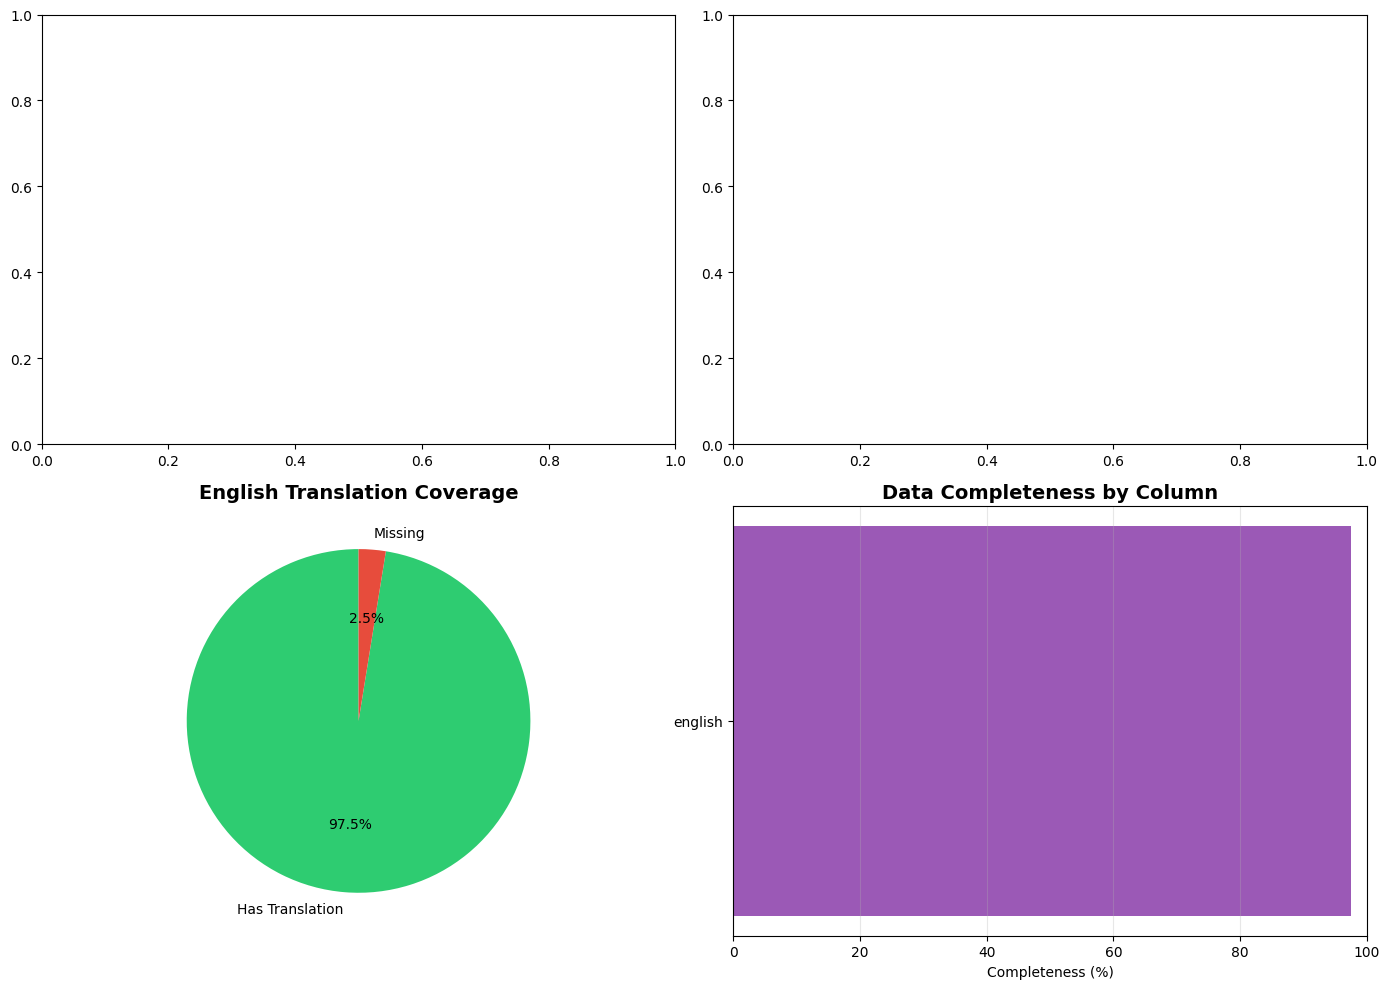

✅ QC visualizations saved to: Connor/data/outputs/lexicon_qc_analysis.png


In [57]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Sentiment distribution
if 'sentiment' in df_enriched.columns:
    sentiment_counts = df_enriched['sentiment'].value_counts()
    axes[0, 0].bar(sentiment_counts.index, sentiment_counts.values, color=['#e74c3c', '#95a5a6', '#2ecc71'])
    axes[0, 0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Score distribution histogram
if 'score' in df_enriched.columns:
    scores = pd.to_numeric(df_enriched['score'], errors='coerce').dropna()
    axes[0, 1].hist(scores, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

# 3. Translation coverage
if 'english' in df_enriched.columns:
    has_english = df_enriched['english'].notna() & (df_enriched['english'].str.strip() != "")
    coverage_data = {'Has Translation': has_english.sum(), 'Missing': (~has_english).sum()}
    axes[1, 0].pie(coverage_data.values(), labels=coverage_data.keys(), autopct='%1.1f%%',
                   colors=['#2ecc71', '#e74c3c'], startangle=90)
    axes[1, 0].set_title('English Translation Coverage', fontsize=14, fontweight='bold')

# 4. Data completeness
completeness = {}
for col in ['french', 'english', 'sentiment', 'score']:
    if col in df_enriched.columns:
        complete = df_enriched[col].notna().sum()
        completeness[col] = (complete / len(df_enriched)) * 100

if completeness:
    axes[1, 1].barh(list(completeness.keys()), list(completeness.values()), color='#9b59b6')
    axes[1, 1].set_title('Data Completeness by Column', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Completeness (%)')
    axes[1, 1].set_xlim(0, 100)
    axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('Connor/data/outputs/lexicon_qc_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ QC visualizations saved to: Connor/data/outputs/lexicon_qc_analysis.png")